In [174]:
import os
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns

In [176]:
n_epochs = 60
n_layers = 1
n_train = 50
n_test = 30

SAVE_PATH = os.path.expanduser("~/Downloads/QARS/Task3_data/")
PREPROCESS = True
np.random.seed(0)
tf.random.set_seed(0)

In [178]:
os.makedirs(SAVE_PATH, exist_ok=True)

In [180]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

train_images = train_images / 255
test_images = test_images / 255

train_images = np.array(train_images[..., np.newaxis], requires_grad=False)
test_images = np.array(test_images[..., np.newaxis], requires_grad=False)

In [182]:
dev = qml.device("default.qubit", wires=4)
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def circuit(phi):
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)
    RandomLayers(rand_params, wires=list(range(4)))
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

In [184]:
def quanv(image):
    out = np.zeros((14, 14, 4))
    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            q_results = circuit([
                image[j, k, 0],
                image[j, k + 1, 0],
                image[j + 1, k, 0],
                image[j + 1, k + 1, 0]
            ])
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

In [186]:
if PREPROCESS:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)

q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


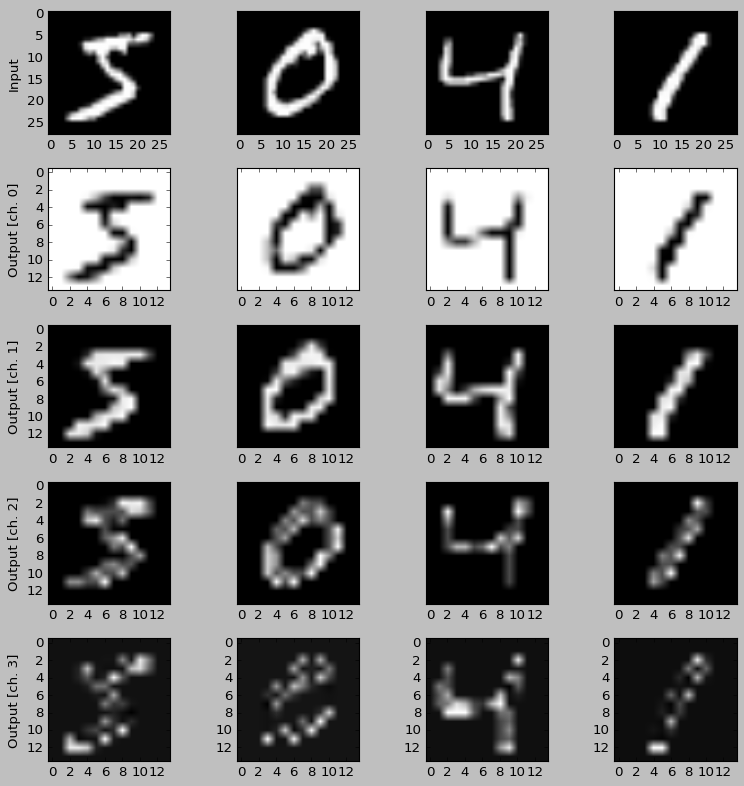

In [188]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

In [190]:
def create_classical_model():
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(28, 28, 1)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [192]:
def create_quantum_model():
    model = keras.models.Sequential([
        keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(14, 14, 4)),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.MaxPooling2D((2, 2)),
        keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        keras.layers.Flatten(),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [194]:
print("Training quantum model...")
q_model = create_quantum_model()
q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2
)

Training quantum model...
Epoch 1/60


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 - 2s - 140ms/step - accuracy: 0.0800 - loss: 2.3609 - val_accuracy: 0.2000 - val_loss: 2.2787
Epoch 2/60
13/13 - 0s - 5ms/step - accuracy: 0.2800 - loss: 2.2131 - val_accuracy: 0.1667 - val_loss: 2.2407
Epoch 3/60
13/13 - 0s - 5ms/step - accuracy: 0.3600 - loss: 2.0603 - val_accuracy: 0.2333 - val_loss: 2.1339
Epoch 4/60
13/13 - 0s - 5ms/step - accuracy: 0.4800 - loss: 1.7978 - val_accuracy: 0.3667 - val_loss: 1.9338
Epoch 5/60
13/13 - 0s - 4ms/step - accuracy: 0.7000 - loss: 1.3814 - val_accuracy: 0.5333 - val_loss: 1.6445
Epoch 6/60
13/13 - 0s - 4ms/step - accuracy: 0.8200 - loss: 0.9198 - val_accuracy: 0.6000 - val_loss: 1.3260
Epoch 7/60
13/13 - 0s - 5ms/step - accuracy: 0.9400 - loss: 0.5357 - val_accuracy: 0.6667 - val_loss: 1.1671
Epoch 8/60
13/13 - 0s - 7ms/step - accuracy: 0.9600 - loss: 0.2414 - val_accuracy: 0.6667 - val_loss: 1.1336
Epoch 9/60
13/13 - 0s - 5ms/step - accuracy: 0.9400 - loss: 0.2429 - val_accuracy: 0.6333 - val_loss: 0.9152
Epoch 10/60
13/13 - 0s - 7ms

In [196]:
print("Training classical model...")
c_model = create_classical_model()
c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2
)

Training classical model...
Epoch 1/60
13/13 - 1s - 72ms/step - accuracy: 0.2000 - loss: 2.3039 - val_accuracy: 0.1333 - val_loss: 2.2446
Epoch 2/60
13/13 - 0s - 7ms/step - accuracy: 0.2800 - loss: 2.1108 - val_accuracy: 0.4000 - val_loss: 1.9795
Epoch 3/60
13/13 - 0s - 7ms/step - accuracy: 0.6000 - loss: 1.5550 - val_accuracy: 0.6667 - val_loss: 1.3941
Epoch 4/60
13/13 - 0s - 7ms/step - accuracy: 0.7400 - loss: 0.8145 - val_accuracy: 0.6000 - val_loss: 1.3152
Epoch 5/60
13/13 - 0s - 7ms/step - accuracy: 0.9600 - loss: 0.2646 - val_accuracy: 0.6333 - val_loss: 1.6356
Epoch 6/60
13/13 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.0754 - val_accuracy: 0.6667 - val_loss: 1.7675
Epoch 7/60
13/13 - 0s - 7ms/step - accuracy: 1.0000 - loss: 0.0350 - val_accuracy: 0.6667 - val_loss: 3.0016
Epoch 8/60
13/13 - 0s - 7ms/step - accuracy: 0.9200 - loss: 0.3190 - val_accuracy: 0.7000 - val_loss: 1.0618
Epoch 9/60
13/13 - 0s - 7ms/step - accuracy: 0.9400 - loss: 0.1541 - val_accuracy: 0.6000 - val_los

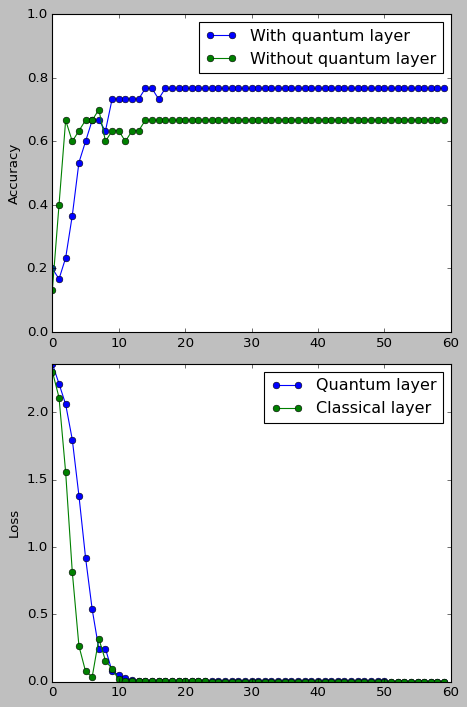

In [200]:
plt.style.use("classic")
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))
if 'q_history' in globals() and 'c_history' in globals():
    ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
    ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
    ax1.set_ylabel("Accuracy")
    ax1.set_ylim([0, 1])
    ax1.legend()

    ax2.plot(q_history.history["loss"], "-ob", label="Quantum layer")
    ax2.plot(c_history.history["loss"], "-og", label="Classical layer")
    ax2.set_ylabel("Loss")
    ax2.set_ylim([0, max(max(q_history.history["loss"]), max(c_history.history["loss"]))])
    ax2.legend()

    plt.tight_layout()
    plt.show()
else:
    print("Error: One or both model histories are not defined.")